![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Eliminación filas con observaciones nulas
data.dropna(inplace=True)
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
data['M_Camry'] = pd.factorize(data.M_Camry)[0]
data['M_Camry4dr'] = pd.factorize(data.M_Camry4dr)[0]
data['M_CamryBase'] = pd.factorize(data.M_CamryBase)[0]
data['M_CamryL'] = pd.factorize(data.M_CamryL)[0]
data['M_CamryLE'] = pd.factorize(data.M_CamryLE)[0]
data['M_CamrySE'] = pd.factorize(data.M_CamrySE)[0]
data['M_CamryXLE'] = pd.factorize(data.M_CamryXLE)[0]

In [8]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)
feature_cols = X.columns

In [6]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

In [8]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 20
max_features = None
min_gain=0.001

In [9]:
# Impresión variable a usar (Mileage)
j = 1
print(X.columns[j])

Mileage


In [10]:
# División de la variable Mileage en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([5.000000e+00, 1.047000e+04, 1.576440e+04, 2.000030e+04,
       2.345860e+04, 2.646100e+04, 2.993760e+04, 3.292670e+04,
       3.570080e+04, 3.872080e+04, 4.168000e+04, 4.479340e+04,
       4.824700e+04, 5.352710e+04, 6.171600e+04, 7.135550e+04,
       8.153420e+04, 9.286500e+04, 1.067578e+05, 1.276100e+05])

In [11]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [12]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [13]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
gini_l

np.float64(-653088556.9195423)

In [14]:
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
gini_r

np.float64(-356990419.20446926)

In [15]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):

    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)

    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)

    return gini_impurity_

In [16]:
# Ganancia de la variable 'Mileage' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

np.float64(8320718.533031642)

In [17]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=20):

    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    # Para todas las varibles
    for j in features:

        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

In [18]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, np.float64(2014.0), np.float64(17349239.621991813))

In [19]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [20]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(10495, 3356, 7139)

In [21]:
y.mean(), y_l.mean(), y_r.mean()

(np.float64(14538.403716055265),
 np.float64(10242.713647199047),
 np.float64(16557.781201848997))

In [22]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace

    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

In [23]:
# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': np.float64(14535.633800133372),
 'level': 0,
 'split': [0, np.float64(2014.0)],
 'n_samples': 10495,
 'gain': np.float64(17349239.621991813),
 'sl': {'y_pred': 1,
  'y_prob': np.float64(10236.613460393091),
  'level': 1,
  'split': -1,
  'n_samples': 3356,
  'gain': np.float64(7787930.328242004)},
 'sr': {'y_pred': 1,
  'y_prob': np.float64(16553.143957428932),
  'level': 1,
  'split': -1,
  'n_samples': 7139,
  'gain': np.float64(3024805.47488904)}}

In [24]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': np.float64(14535.633800133372),
 'level': 0,
 'split': [0, np.float64(2014.0)],
 'n_samples': 10495,
 'gain': np.float64(17349239.621991813),
 'sl': {'y_pred': 1,
  'y_prob': np.float64(10236.613460393091),
  'level': 1,
  'split': [0, np.float64(2012.0)],
  'n_samples': 3356,
  'gain': np.float64(7787930.328242004),
  'sl': {'y_pred': 1,
   'y_prob': np.float64(8765.27302174919),
   'level': 2,
   'split': [1, np.float64(97405.90909090909)],
   'n_samples': 2159,
   'gain': np.float64(2255536.2609175444),
   'sl': {'y_pred': 1,
    'y_prob': np.float64(9916.894201424211),
    'level': 3,
    'split': -1,
    'n_samples': 981,
    'gain': np.float64(1653234.7266777754)},
   'sr': {'y_pred': 1,
    'y_prob': np.float64(7791.058474576271),
    'level': 3,
    'split': -1,
    'n_samples': 1178,
    'gain': np.float64(1289639.2187613398)}},
  'sr': {'y_pred': 1,
   'y_prob': np.float64(12871.387823185989),
   'level': 2,
   'split': [1, np.float64(73275.7272727272

In [25]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):

    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']

    else:

        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [26]:
# Ejecución de función tree_predict
#tree_predict(X, tree)


In [27]:
# Obtención de las predicciones en el conjunto de test
predictions = tree_predict(X_test, tree)

# Verifica que las dimensiones de las predicciones y y_test coincidan
print(f"Tamaño de predicciones: {len(predictions)}")
print(f"Tamaño de y_test: {len(y_test)}")

# Asegúrate de que las predicciones y los valores reales tengan la misma longitud
if len(predictions) == len(y_test):
    # Cálculo del RMSE y MAE
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import numpy as np

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
else:
    print("Error: Las dimensiones de las predicciones y y_test no coinciden. Revisa los datos.")


Tamaño de predicciones: 3464
Tamaño de y_test: 3464
Root Mean Squared Error (RMSE): 15113.767253661932
Mean Absolute Error (MAE): 14598.966224018475


RMSE: El valor es 15113.77. En este caso, un RMSE alto sugiere que las predicciones presentan desviaciones significativas.
MAE: en promedio, el modelo está cometiendo un error de 14,598.97 unidades en cada predicción.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [28]:
# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))


Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


In [29]:
# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = data.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 3824, 2046, 2560]),
 array([1999, 4774,  173, ..., 5803,  742, 5039]),
 array([2114, 4003, 3565, ..., 2965,  679, 2539]),
 array([ 6265,  2062,  9901, ...,  8182,  8981, 10457]),
 array([ 1727,  9002, 10082, ...,  9627,  6818,  2533]),
 array([ 9342,  8135,  1731, ..., 10225,  1367,  9054]),
 array([10297,  4474,  4234, ..., 10043,  4228,  5067]),
 array([9836, 9902, 5024, ..., 1281, 3089, 3668]),
 array([ 4266,  6769, 10150, ...,  7107,  7829,  8145]),
 array([6838,   84, 6064, ..., 5539,  847, 9812])]

In [30]:
# Visualización muestra boostrap #1 para entremiento
data.iloc[samples[0], :]

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
137130,8995,2010,88909,0,0,0,1,1,0,0
51669,16500,2015,27217,0,0,0,1,0,1,0
199443,13695,2012,77117,0,1,0,1,0,0,0
292826,19999,2016,35504,0,0,0,1,0,1,0
372365,17302,2017,14738,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
206104,15800,2015,33395,0,0,0,1,1,0,0
160997,17000,2014,28864,0,0,0,1,0,0,1
146432,17295,2016,30214,0,0,0,1,1,0,0
78810,14777,2014,54924,0,0,0,0,0,0,0


In [31]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=data.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train2 = data.iloc[sample, 1:]
    y_train2 = data.iloc[sample, 0]
    treereg.fit(X_train2, y_train2)
    y_pred.iloc[:,i] = treereg.predict(X)

y_pred

,0,1,2,3,4,5,6,7,8,9
7,21995.0,21995.0,15997.0,21995.0,21995.0,21995.0,21995.0,21995.0,21995.0,18700.0
11,13995.0,14500.0,13988.0,14750.0,13988.0,13995.0,13995.0,13995.0,13995.0,13988.0
167,18000.0,17941.0,17941.0,19994.0,17941.0,17941.0,17941.0,17941.0,17941.0,19994.0
225,12493.0,12493.0,12493.0,16903.0,14999.0,12493.0,12493.0,15579.0,14999.0,14369.0
270,7994.0,6494.0,7994.0,6495.0,7994.0,11995.0,7994.0,6494.0,7994.0,6494.0
...,...,...,...,...,...,...,...,...,...,...
399845,21000.0,20825.0,20825.0,20825.0,19950.0,20825.0,20825.0,20774.0,17595.0,20825.0
399928,12995.0,12995.0,12995.0,12995.0,14590.0,12995.0,14590.0,12995.0,14590.0,12995.0
399934,6900.0,7988.0,8812.0,8812.0,6940.0,10500.0,8812.0,6900.0,8812.0,8812.0
399951,11595.0,11595.0,11595.0,11595.0,11595.0,11595.0,11595.0,8881.0,8881.0,11595.0


In [32]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y)))

Árbol  0 tiene un error:  1306.9871286148239
Árbol  1 tiene un error:  1276.0853969826583
Árbol  2 tiene un error:  1321.8929753792552
Árbol  3 tiene un error:  1278.697692073542
Árbol  4 tiene un error:  1293.9416032254699
Árbol  5 tiene un error:  1288.2035995426586
Árbol  6 tiene un error:  1287.8467638609518
Árbol  7 tiene un error:  1281.488561204204
Árbol  8 tiene un error:  1285.692932775307
Árbol  9 tiene un error:  1316.92557440069


In [33]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

,0
7,21065.7
11,14118.9
167,18357.5
225,13931.4
270,7794.2
...,...
399845,20426.9
399928,13473.5
399934,8328.8
399951,11052.2


In [34]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y, y_pred.mean(axis=1)))

np.float64(744.9839911417182)

El RMSE = 745 significa que, en promedio, las predicciones del modelo de Bagging están a 745 unidades de los valores reales respecto a los precios reales del automovil. Es decir, las predicciones del modelo están desviadas en promedio 745 unidades respecto a los precios verdaderos.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [35]:
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                          bootstrap=True, oob_score=True, random_state=1)


In [36]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([13160.69,  6520.77, 16406.15, ..., 21536.82, 12894.99, 11818.55])

In [37]:
# Cálculo del error del modelo
np.sqrt(mean_squared_error(y_test, y_pred))

np.float64(1755.494590149069)

El valor de RMSE = 1251 significa que, en promedio, las predicciones del modelo están a 1251 unidades de los valores reales. Para nuestro caso sería bajo por el rango de los valores de los automóviles.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [17]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
reg = RandomForestRegressor()
reg

print('Metrica de desempeno:')
print(pd.Series(cross_val_score(reg, X, y, cv=10, scoring='r2')).describe())

# Evaluación del desempeño en RMSE
rmse_scores = cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')
rmse_scores = -rmse_scores  # Convertir a valores positivos
print("\nDesempeño en RMSE:")
print(pd.Series(rmse_scores).describe())

Metrica de desempeno:
count    10.000000
mean      0.801209
std       0.011508
min       0.780953
25%       0.795997
50%       0.803031
75%       0.806345
max       0.817589
dtype: float64

Desempeño en RMSE:
count      10.000000
mean     1746.236729
std        53.451985
min      1684.793848
25%      1694.589472
50%      1741.069206
75%      1790.499601
max      1817.370605
dtype: float64


Este modelo de random forest contiene los parámetros por defecto que vienen dentro de la libreria sklearn. Tras realizar la validación cruzada, se observa un R2 de 0.80, lo que significa que al menos el 80% de los datos se predicen de manera correcta. Existe una leve diferencia entre los valores minimos y maximos, lo cual, aunque no de manera extrema demuestra diferencias entre el peor y mejor resultado. Por su parte, la mayoría de los resultados se encuentran alrededor del 0.80, tal como se aprecia con los percentiles.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### Calibracion max_depth

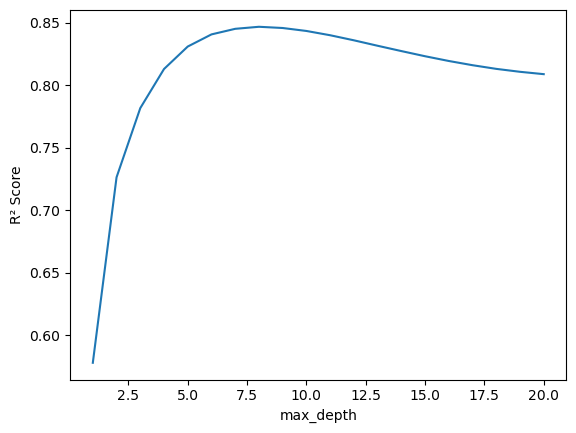

Mejor R² para max_depth: 0.8467 con max_depth = 8


In [5]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de depth
depth_range = range(1, 21)

# Definición de lista para almacenar el R2 para cada valor de depth
r2_scores_depth = []

# Uso de un 5-fold cross-validation para cada valor de depth
for depth in depth_range:
    reg = RandomForestRegressor(n_estimators=200, max_depth=depth, random_state=1, n_jobs=-1)
    r2_scores_depth.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de depth
plt.plot(depth_range, r2_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('R² Score')
plt.show()

best_depth = depth_range[r2_scores_depth.index(max(r2_scores_depth))]
best_r2_depth = max(r2_scores_depth)
print(f"Mejor R² para max_depth: {best_r2_depth:.4f} con max_depth = {best_depth}")

### Calibracion n_estimators

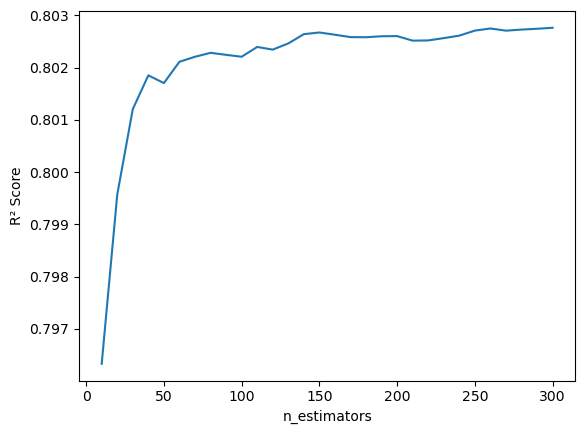

Mejor R² para n_estimators: 0.8028 con n_estimators = 300


In [6]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar el R2 promedio para cada valor de n_estimators
r2_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    r2_scores.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, r2_scores)
plt.xlabel('n_estimators')
plt.ylabel('R² Score')
plt.show()

best_estimators = estimator_range[r2_scores.index(max(r2_scores))]
best_r2_estimators = max(r2_scores)
print(f"Mejor R² para n_estimators: {best_r2_estimators:.4f} con n_estimators = {best_estimators}")

### Calibracion max_features

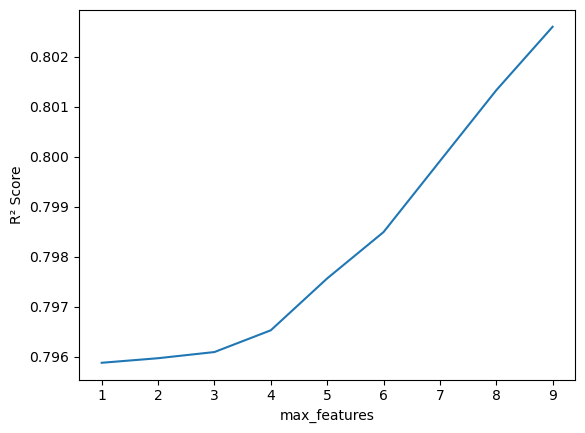

Mejor R² para max_features: 0.8026 con max_features = 9


In [9]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar el R2 promedio para cada valor de max_features
r2_scores_features = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    reg = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    r2_scores_features.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, r2_scores_features)
plt.xlabel('max_features')
plt.ylabel('R² Score')
plt.show()

best_feature = feature_range[r2_scores_features.index(max(r2_scores_features))]
best_r2_feature = max(r2_scores_features)
print(f"Mejor R² para max_features: {best_r2_feature:.4f} con max_features = {best_feature}")

### Implementacion de un Random Forest con los mejores parametros

In [14]:
# Definición del modelo con los nuevos parámetros 
reg = RandomForestRegressor(max_depth=8, n_estimators=300, max_features=9, random_state=1, n_jobs=-1)
reg.fit(X, y)

# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':feature_cols, 'importance':reg.feature_importances_}).sort_values('importance')

print('Metricas de desempeno:')
print(pd.Series(cross_val_score(reg, X, y, cv=10, scoring='r2')).describe())

# Desempeño en RMSE
rmse_scores = cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')
rmse_scores = -rmse_scores  # Convertir a valores positivos
print("\nDesempeño en RMSE:")
print(pd.Series(rmse_scores).describe())

Metricas de desempeno:
count    10.000000
mean      0.847390
std       0.012100
min       0.829346
25%       0.839241
50%       0.848183
75%       0.855108
max       0.865723
dtype: float64

Desempeño en RMSE:
count      10.000000
mean     1530.005104
std        63.133062
min      1442.440719
25%      1483.721915
50%      1523.433078
75%      1565.856214
max      1658.944983
dtype: float64


En el presente modelo se realizan los ajustes para tres parámetros (max_depth, n_estimatos, max_features) con el proposito de mejorar la predicción. Empezando, se realiza un recorrido desde 1 hasta 21 para probar el valor más óptimo de la profundización del árbol. El valor más adecuado es 8, y se observa que a medida que se profundiza el árbol de decisiones, el error R2 disminuye. El segundo parámetro es el n_estimatos, en el cual se evaluan varios parametros dentro del rango 10 hasta 310, sin embargo, aunque no se observe en el codigo, se realizaron varias pruebas ampliando el rango hasta 510. Lo anterior permitió observar que el valor de R2, por encima de 150 se mantiene muy plano, con leves cambios en el error promedio. Por lo anterior, se limita el rango unicamente hasta 310 y se escoge 300 como el valor n_estimatos más óptimo. Por último, se calculan los parámetros max_features. Graficamente, se observa que al aumentar los valores max_features, el error R2 aumenta, sin embargo, se establece como rango de iteración la longitud que tiene la columna de predicción, por lo cual, se escoge 9 como el valor óptimo de max_features.

Los anteriores parámetros calibrados se implementan dentro del codigo de Random Forest. Estos arrojan un mejor R2 respecto al primer modelo de random forest elaborado, prediciendo en un 84% el conjunto de datos. La baja desviación estandar sugiere que el desempeño es consistente entre los folds, siendo un modelo estable. De igual manera, los valores extremos como el mínimo y máximo se reducen, lo que desmuestra poca variación entre el peor y mejor resultado. Por otra parte, los percentiles no demuestran mucha diferencia, por lo cual, los resultados se encuentran entre el 0.83 y 0.84, siendo un modelo consistente.

La calibración de los tres parámetros nombrados anteriormente, mejoran los resultados generales, sin embargo, no permiten mejorar por encima del 90% las predicciones.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
from xgboost import XGBRegressor
from sklearn import metrics


clf = XGBRegressor()
clf

# Entenamiento y desempeño del modelo XGBRegressor
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.root_mean_squared_error(y_test, y_pred),metrics.mean_absolute_error(y_test, y_pred)



El desempeño del XGBoost es el siguiente en tanto a las métricas de error:

RMSE: 1605.23


MAE: 1185.22

En comparación a los otros modelos, el RMSE es mejor en comparación al de arboles de decisión pero Bagging sigue siendo la mejor opción.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [41]:
# Celda 7
clf = XGBRegressor(learning_rate=0.05,gamma= 3, colsample_bytree= 0.8)
clf

# Entenamiento y desempeño del modelo XGBRegressor
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.root_mean_squared_error(y_test, y_pred),metrics.mean_absolute_error(y_test, y_pred)


(1549.789306640625, 1136.365966796875)

En tanto a la calibración del modelo se escogieron los siguientes valores para cada uno de los parametros a sensibilizar:

learning_rate=0.05,gamma= 3, colsample_bytree= 0.8

Con el learning_rate, el modelo puede llegar a aprender más lento pero reducimos el posible sobreajuste.

Con el gamma se pretende colocar una reducción de la perdida minima requerida para partir un arbol. Entre más grande sea, mejor podemos evitar el sobreajuste.

Con colsample_bytree, el porcentaje de los datos en las columnas son seleccionados para la construcción de un arbol. Esto puede llegar a ser util para entender y capturar diferentes rasgos de los datos.

Los valores del RMSE y el MAE son menores que el XGBoost sin calibración el los parámetros, lo que indica mejores resultados al reducir el error:

RMSE calibrado: 1549.78

RMSE sin calibrar: 1605.23

MAE calibrado: 1136.36

MAE sin calibrar: 1185.22

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

De acuerdo a los resultados obtenidos:

Arboles de decisión: RMSE = 15113.77

Bagging (Manual): El RMSE = 745

Bagging (librerias): El RMSE = 1251

Random Forest con parametros por defecto: El RMSE = 1746.23

Random Fores con parametros calibrados: El RMSE = 1530.00

XGboost sin calibrar: El RMSE = 1605.23

XGBoost calibrado : El RMSE = 1549.78

Podríamos concluir que el mejor modelo para predecir el precio del automóvil sería el Bagging (Manual), ya que presenta el menor valor de RMSE = 745. Esto representa una ventaja significativa porque un RMSE reducido implica que las predicciones del modelo son más precisas y están más cercanas a los valores reales, lo que mejora la confiabilidad del modelo para tomar decisiones basadas en estas estimaciones. Además, un error menor reduce la incertidumbre y permite implementar estrategias con mayor nivel de precisión, optimizando así tanto el análisis de precios como las proyecciones futuras.

De manera general, Bagging manual es, por mucho, el mejor modelo en este caso, con un RMSE de apenas 745, lo cual indica una gran precisión respecto a los demás.

Random Forest y XGBoost calibrados mejoran notablemente respecto a sus versiones por defecto, lo que muestra que la calibración de hiperparámetros sí vale la pena.

El árbol de decisión individual tiene un RMSE excesivamente alto (15113.77), lo que confirma que los modelos de ensamblaje (bagging, RF, XGBoost) generalizan mucho mejor que un solo árbol.